In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import cv2
import tensorly as tl
from scipy.sparse.linalg import svds
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split

## Generation of a spatial matrix

In [2]:
def gen_mat_by_gaussians(means, covs, size, nx, ny):
    size_per_dist = int(size) // len(means)
    X, Y = [], []
    for mean, cov in zip(means, covs):
        x, y = np.random.multivariate_normal(mean, cov, size_per_dist).T
        X.extend(x)
        Y.extend(y)
        
    X = np.array(X)
    Y = np.array(Y)
    # We want first dimension (rows) to be Y
    M, _, _ = np.histogram2d(Y, X, bins=(np.arange(ny), np.arange(nx)))
    
    return M

In [3]:
size = 800000
nx = 406
ny = 482

means = [
    [60, 60],
    [140, 90],
    [220, 300],
    [320, 400]
]

covs = [
    [[800, 0],
     [0, 800]],
    [[450, 200],
     [200, 450]],
    [[650, 100],
     [100, 850]],
    [[700, 0],
     [0, 600]]
]

M = gen_mat_by_gaussians(means, covs, size, nx, ny)
M.min(), M.mean(), M.max(), M.shape

(0.0, 4.071348271348271, 100.0, (481, 405))

## Add temporal evolution to the matrix and form spatio-temporal tensor (aka art_tensor)

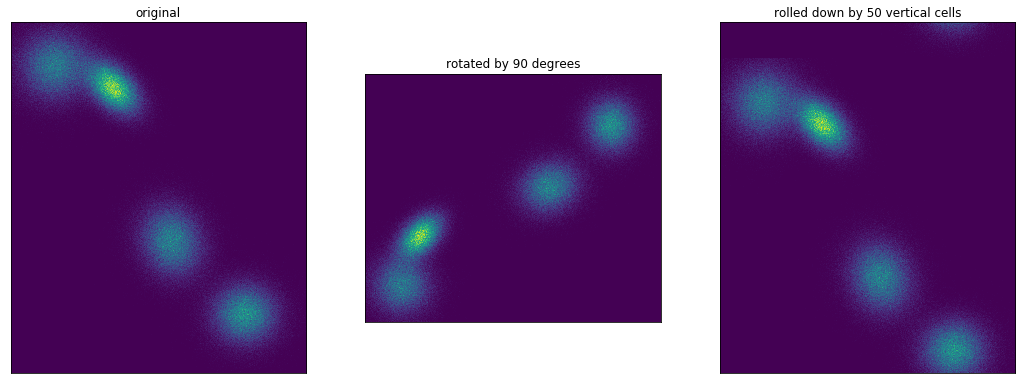

In [4]:
# We assume that matrix evolution is simply an affine transformation

fig = plt.figure(figsize=(18, 10))
ax_lst = fig.subplots(1, 3)

ax_lst[0].set_title('original')
ax_lst[0].imshow(M)

ax_lst[1].set_title('rotated by 90 degrees')
ax_lst[1].imshow(rotate(M, 90))

ax_lst[2].set_title('rolled down by 50 vertical cells')
ax_lst[2].imshow(np.roll(M, 50, axis=0))

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
def get_evolved_pts(src_pts, evolution_speed, evolution_angle_range):
    dst_pts = []
    for x, y in src_pts:
        r = np.random.uniform(0, evolution_speed)
        phi = np.random.uniform(evolution_angle_range[0], evolution_angle_range[1])
        dst_pts.append([x + r * np.cos(phi), y + r * np.sin(phi)])
    return np.float32(dst_pts)
    
    
def evolute_mat(X, evolution_speed, evolution_angle_range):
    y_len, x_len = X.shape
    src_pts = np.float32([[0, 0], [x_len - 1, 0], [0, y_len - 1]])
    dst_pts = get_evolved_pts(src_pts, evolution_speed, evolution_angle_range)
    affine_matrix = cv2.getAffineTransform(src_pts, dst_pts)
    X_evolved = cv2.warpAffine(X, affine_matrix, (x_len, y_len))
    return X_evolved


def create_evolution_tensor(init_mat, 
                            zsize,
                            gaussian_supplements,  # {gaussians, iters} - add flashes
                            evolution_speed=5, 
                            evolution_angle_range=[1.5 * np.pi, 2 * np.pi]):
    mat = init_mat
    tensor = [mat]
    for step_num in range(zsize - 1):
        mat = evolute_mat(mat, evolution_speed, evolution_angle_range)
        
        if step_num in gaussian_supplements['iters']:
            ind = gaussian_supplements['iters'].index(step_num)
            mat += gaussian_supplements['gaussians'][ind]
            
        tensor.append(mat)
        
    tensor = np.array(tensor)
    tensor = np.moveaxis(tensor, 0, -1)
    return tensor

In [6]:
zsize = 92
gaussian_supplements = {
    'gaussians': [
         gen_mat_by_gaussians(means=[[75, 250]],
                              covs=[[[20, 5], [5, 10]]],
                              size=size/len(means)/100,
                              nx=nx, ny=ny),
         gen_mat_by_gaussians(means=[[250, 200]],
                              covs=[[[5, 1], [1, 3]]],
                              size=size/len(means)/100,
                              nx=nx, ny=ny)
     ],
     'iters': [15, 55]
}

art_tensor = create_evolution_tensor(M, 
                                     zsize=zsize, 
                                     gaussian_supplements=gaussian_supplements,
                                     evolution_speed=2,
                                     evolution_angle_range=[0, 0.5 * np.pi])

art_tensor.shape

(481, 405, 92)

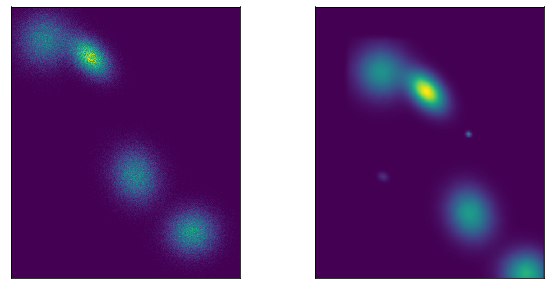

In [7]:
fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(art_tensor[:, :, 0])
ax_lst[1].imshow(art_tensor[:, :, 91])

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
art_tensor.mean(), art_tensor.min(), art_tensor.max(), art_tensor.std() 

(4.033254203919488, 0.0, 100.0, 9.737265964563269)

## Add noise

In [9]:
def add_noise(M, mean=0, var=1):
    copied_mat = M.copy()
    noise = np.random.normal(mean, var, size=copied_mat.shape)
    copied_mat += noise
    return copied_mat

In [10]:
noised_art_tensor = add_noise(art_tensor, mean=0, var=2)
noised_art_tensor[noised_art_tensor < 0] = 0

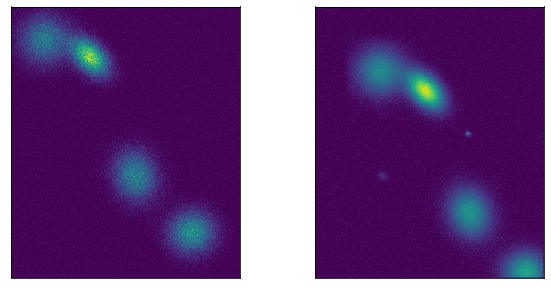

In [11]:
fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(noised_art_tensor[:, :, 0])
ax_lst[1].imshow(noised_art_tensor[:, :, 90])

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
noised_art_tensor.mean(), noised_art_tensor.min(), noised_art_tensor.max(), noised_art_tensor.std() 

(4.599375781825876, 0.0, 97.82717552127862, 9.618187490558764)

## Add clouds

In [13]:
# We now we assume that clouds are uniformly distributed, it's obviously not natural,
# but to keep things simple we accept that on the artificial stage

def add_clouds(art_tensor, cloud_coverage_percentage):
    cloud_art_tensor = art_tensor.copy()

    for t in range(art_tensor.shape[2]):
        mat = cloud_art_tensor[:, :, t]
        cloud_size = int(mat.size*cloud_coverage_percentage/100)
        x_inds = np.random.randint(0, mat.shape[1], size=cloud_size)
        y_inds = np.random.randint(0, mat.shape[0], size=cloud_size)
        for x, y in zip(x_inds, y_inds):
            mat[y, x] = np.nan
        cloud_art_tensor[:, :, t] = mat
        
    return cloud_art_tensor

In [14]:
cloud_noised_art_tensor = add_clouds(noised_art_tensor, cloud_coverage_percentage=30)

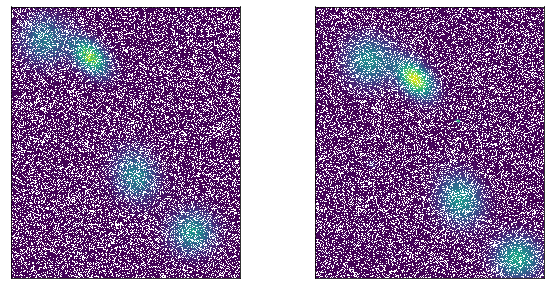

In [15]:
fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(cloud_noised_art_tensor[:, :, 0])
ax_lst[1].imshow(cloud_noised_art_tensor[:, :, 62])

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])

## Run DINEOF

In [63]:
# Implement DINEOF estimator
class DINEOF(BaseEstimator):
    def __init__(self, K=5,
                 original_tensor=noised_art_tensor,
                 nitemax=300, toliter=1e-3, tol=1e-8, to_center=True, 
                 keep_positive_only=True):
        self.K = K
        self.nitemax = nitemax
        self.toliter = toliter
        self.tol = tol
        self.to_center = to_center
        self.keep_positive_only = keep_positive_only
        self.info = ""
        self.original_tensor = original_tensor
        self.reconstructed_tensor = None
        self.singular_values_ = None
        self.ucomponents_ = None
        self.vtcomponents_ = None
        
    def score(self, X, y):
        y_hat = self.predict(X)
        meaned_sqd_diff = np.mean(np.power(y_hat - y, 2))
        # "-" to get bigger values for better fit (according to sklearn)
        return -np.sqrt(meaned_sqd_diff) / np.std(y)
        
    def predict(self, X):
        output = np.array([self.reconstructed_tensor[data[0], data[1], data[2]] for data in X])
        return output
        
    def fit(self, X, y):
        # X - in format (lat, lon, t) here
        # Target of this func to prepare input for _fit
        tensor = np.full(self.original_tensor.shape, np.nan)
        for i, data in enumerate(X):
            lat, lon, t = data
            tensor[lat, lon, t] = y[i]
        
        self._fit(self.rectify_tensor(tensor))
        
    def _fit(self, X):
        # X - as 2D image here
        if self.to_center:
            X, *means = self.center_2d_mat(X)

        # Initial guess
        nan_mask = np.isnan(X)
        X[nan_mask] = 0

        for i in range(self.nitemax):
            u, s, vt = svds(X, k=self.K, tol=self.tol)
            X_hat = u @ np.diag(s) @ vt
            X_hat[~nan_mask] = X[~nan_mask]
            diff_in_clouds = X_hat[nan_mask] - X[nan_mask]
            conv_error = np.linalg.norm(diff_in_clouds) / np.std(X[~nan_mask])
            X = X_hat
            if conv_error <= self.toliter:
                break

        if self.to_center:
            X = self.decenter_2d_mat(X, *means)

        if self.keep_positive_only:
            X[X < 0] = 0

        self.info += f'iter made: {i}, convergence error: {conv_error:.04f}\n'
        self.reconstructed_tensor = self.unrectify_mat(X, spatial_shape=self.original_tensor.shape[:-1])
        self.singular_values_ = s
        self.ucomponents_ = u
        self.vtcomponents_ = vt
    
    def rectify_tensor(self, tensor):
        rect_mat = []
        for t in range(tensor.shape[-1]):
            rect_mat.append(tensor[:, :, t].flatten())
        rect_mat = np.array(rect_mat)
        rect_mat = np.moveaxis(rect_mat, 0, -1)
        return rect_mat

    def unrectify_mat(self, mat, spatial_shape):
        tensor = []

        for t in range(mat.shape[-1]):
            col = mat[:, t]
            unrectified_col = col.reshape(spatial_shape)
            tensor.append(unrectified_col)

        tensor = np.array(tensor)
        tensor = np.moveaxis(tensor, 0, -1)

        return tensor

    def center_2d_mat(self, mat):
        nan_mask = np.isnan(mat)
        temp_mat = mat.copy()
        temp_mat[nan_mask] = 0

        m0 = temp_mat.mean(axis=0)
        for i in range(temp_mat.shape[0]):
            temp_mat[i, :] -= m0

        m1 = temp_mat.mean(axis=1)
        for i in range(temp_mat.shape[1]):
            temp_mat[:, i] -= m1

        temp_mat[nan_mask] = np.nan
        return temp_mat, m0, m1

    def decenter_2d_mat(self, mat, m0, m1):
        temp_mat = mat.copy()

        for i in range(temp_mat.shape[0]):
            temp_mat[i, :] += m0

        for i in range(temp_mat.shape[1]):
            temp_mat[:, i] += m1

        return temp_mat

In [51]:
# Prepare data for CV with DINEOF
t_range = np.arange(cloud_noised_art_tensor.shape[2])
lats_range = np.arange(cloud_noised_art_tensor.shape[0])
lons_range = np.arange(cloud_noised_art_tensor.shape[1])

lat = np.array([lat for _ in t_range for lat in lats_range for _ in lons_range])
lon = np.array([lon for _ in t_range for _ in lats_range for lon in lons_range])
t = np.array([t for t in t_range for _ in lats_range for _ in lons_range])
y = np.moveaxis(cloud_noised_art_tensor, -1, 0).flatten()

noised_art_df = pd.DataFrame({
    'lon': lon,
    'lat': lat,
    't': t,
    'y': y
})
noised_art_df_na = noised_art_df[noised_art_df['y'].isnull()]
noised_art_df.dropna(inplace=True)

X_train = noised_art_df[['lat', 'lon', 't']].to_numpy()
y_train = noised_art_df['y'].to_numpy()

# X_test = noised_art_df_na[['lat', 'lon', 't']].to_numpy()
# y_test = np.array([noised_art_tensor[data[0], data[1], data[2]] for data in X_test])

# interesting_indices = np.argsort(y_test)[-30000:]
# X_test_new = X_test[interesting_indices]
# y_test_new = y_test[interesting_indices]

In [67]:
dineof = GridSearchCV(DINEOF(), {'K': [1, 2]}, cv=10)

dineof.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DINEOF(K=5, keep_positive_only=True, nitemax=300,
                              original_tensor=array([[[5.22108510e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.39393158e+00, 0.00000000e+00, 0.00000000e+00],
        [4.10982640e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.17954573e-04, 6.08872049e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e...
        [1.34092475e-02, 0.00000000e+00, 0.00000000e+00, ...,
         4.34460892e+00, 6.28003892e+00, 2.08111005e+01],
        [2.21483022e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.67792808e-01, 0.00000000e+00, 1.29291197e+01]]]),
                              to_center=True, tol=1e-08, toliter=0.001),
             iid='deprecated', n_jobs=None, param_grid={'K': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [71]:
dineof.cv_results_

{'mean_fit_time': array([122.48805017, 178.90124569]),
 'std_fit_time': array([ 92.98047975, 171.41073812]),
 'mean_score_time': array([1.79839785, 1.50415232]),
 'std_score_time': array([0.27743326, 0.20468119]),
 'param_K': masked_array(data=[1, 2],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'K': 1}, {'K': 2}],
 'split0_test_score': array([-0.841735  , -0.84124679]),
 'split1_test_score': array([-0.75240765, -0.7494426 ]),
 'split2_test_score': array([-0.70782312, -0.69675288]),
 'split3_test_score': array([-0.66945216, -0.64386677]),
 'split4_test_score': array([-0.65423103, -0.64988197]),
 'split5_test_score': array([-0.65606102, -0.65433875]),
 'split6_test_score': array([-0.68562467, -0.64244642]),
 'split7_test_score': array([-0.71318567, -0.69838421]),
 'split8_test_score': array([-0.76580398, -0.76101994]),
 'split9_test_score': array([-0.8573212 , -0.85775733]),
 'mean_test_score': array([-0.73036455, -0.71951377]),
 's

In [76]:
dineof.best_score_

-0.7195137672651101

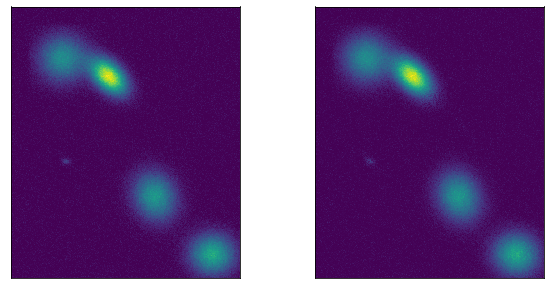

In [79]:
n = 55
fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(dineof.best_estimator_.original_tensor[:, :, n])
ax_lst[1].imshow(dineof.best_estimator_.reconstructed_tensor[:, :, n])

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])

## Demean tensor

In [403]:
def center_3d_tensor(tensor):
    nan_mask = np.isnan(tensor)
    temp_tensor = tensor.copy()
    temp_tensor[nan_mask] = 0
    
    m0 = temp_tensor.mean(axis=0)
    for i in range(temp_tensor.shape[0]):
        temp_tensor[i, :, :] -= m0
    
    m1 = temp_tensor.mean(axis=1)
    for i in range(temp_tensor.shape[1]):
        temp_tensor[:, i, :] -= m1
    
    m2 = temp_tensor.mean(axis=2)
    for i in range(temp_tensor.shape[2]):
        temp_tensor[:, :, i] -= m2
    
    temp_tensor[nan_mask] = np.nan
    return temp_tensor

demeaned_cloud_noised_art_tensor = center_3d_tensor(cloud_noised_art_tensor)

fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(demeaned_cloud_noised_art_tensor[:, :, 0])
ax_lst[1].imshow(demeaned_cloud_noised_art_tensor[:, :, 90])

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])

## Run tensors decomposition to recover data

In [ ]:
def tHOSVD(tensor, r1, r2, r3):
    